In [67]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate

In [68]:
srcdir = "../../../data/eval/webarena/230922/"

In [ ]:
dfs = []

for filename in os.listdir(srcdir):
    if filename.endswith(".csv"):
        filepath = os.path.join(srcdir, filename)
        df = pd.read_csv(filepath)
        df['config'] = df['config_file'].str.extract('(\d+)', expand=False).astype(int)
        dfs.append(df)

df_file = pd.concat(dfs, ignore_index=True)
df = df_file

df['success'] = df['success'].apply(lambda x: float(eval(x)) if isinstance(x, str) else float(x))

# Overwrite row with best metric val from concatenated dataframe
df_group = df.groupby(['config', 'policy'])

max_metric = df_group['success'].max()
df = df_group.first().reset_index()
df['success'] = max_metric.values

print(len(df))
df.head(5)

In [ ]:
# Insepct CSV
lower_policy = 'flat_fewshot'
upper_policy = 'paw_fewshot'

lower_df = df[df['policy'] == lower_policy]
upper_df = df[df['policy'] == upper_policy]

merged_df = pd.merge(lower_df, upper_df, on='config', suffixes=('_lower', '_upper'))

filtered_df = merged_df[merged_df['success_upper'] < merged_df['success_lower']]

result_df = filtered_df[['config', 'policy_lower', 'config_file_lower', 'site_lower', 'success_lower', 'task_progress_lower', 'num_actions_lower']]
result_df.columns = ['config', 'policy', 'config_file', 'site', 'success', 'task_progress', 'num_actions']
result_df['policy'] = upper_policy

result_df = result_df.drop(columns=['config'])

column_order = ['config_file', 'site', 'policy', 'success', 'task_progress', 'num_actions']
result_df = result_df[column_order]

import time
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = f"{timestr}.csv"
result_df.to_csv(filename, index=False)

print(result_df)

In [71]:
# Tasks
tasks = {
    'gitlab_check_status': [44, 45, 46, 156, 258, 259, 357],
    'gitlab_count_commits': [132, 133, 134, 135, 136, 205, 206, 207, 303, 304, 305, 306, 307],
    'gitlab_search_issue': [173, 174, 175, 176, 177, 178, 179, 180, 181, 182],
    'gitlab_user_details': [784, 785, 786, 787, 788, 308, 309, 310, 311, 312, 168, 169, 170, 171, 172],
    'gitlab_create_repo': [475, 476, 477, 478, 479, 752, 753, 754, 755, 756],
    'gitlab_create_issue': [742, 743, 744, 745, 746, 747, 748, 749, 750, 751],
    'maps_location_lookup': [70, 71, 72, 73, 248, 249, 250, 251],
    'maps_info_lookup': [253, 254, 255, 256, 257, 369, 370, 371, 372, 373],
    'maps_travel_time': [36, 37, 38, 39, 40, 137, 138, 139, 140, 150, 151, 152, 153, 154, 155, 287],
    'maps_closest_location': [57, 58, 59, 60, 61, 377, 378, 379, 380, 381],
    'maps_relative_directions': [84, 85, 86, 87, 88, 221, 222, 223, 224],
    'maps_multi_stop': [80, 81, 82, 83, 74, 75, 76]
}

task_name_mapping = {}

for task, task_list in tasks.items():
    task_name = f"{task} [{len(task_list)}]"
    task_name_mapping[task] = task_name

# Create a reverse mapping from the tasks dictionary
reverse_tasks = {config: task for task, configs in tasks.items() for config in configs}
# Create a new task column in the dataframe
df['task'] = df['config'].map(reverse_tasks)

# Convert the 'task' column to a Categorical type with the specified order
df['task'] = pd.Categorical(df['task'], categories=tasks.keys(), ordered=True)

# Sort the dataframe by the 'task' column
avg_success_df = df.sort_values(by='task')

In [74]:
# Group by 'task' and 'policy' and compute the mean of 'success'
avg_success_df = df.groupby(['task', 'policy'])['success'].mean().reset_index()

# Rename the 'success' column to 'average_success'
avg_success_df = avg_success_df.rename(columns={'success': 'average_success'})

print(avg_success_df)

                        task         policy  average_success
0        gitlab_check_status   flat_fewshot         0.714286
1        gitlab_check_status  flat_zeroshot         0.714286
2        gitlab_check_status    paw_fewshot         0.857143
3        gitlab_check_status   paw_zeroshot         0.857143
4       gitlab_count_commits   flat_fewshot         0.307692
5       gitlab_count_commits  flat_zeroshot         0.230769
6       gitlab_count_commits    paw_fewshot         0.615385
7       gitlab_count_commits   paw_zeroshot         0.230769
8        gitlab_search_issue   flat_fewshot         0.000000
9        gitlab_search_issue  flat_zeroshot         0.000000
10       gitlab_search_issue    paw_fewshot         0.600000
11       gitlab_search_issue   paw_zeroshot         0.000000
12       gitlab_user_details   flat_fewshot         0.133333
13       gitlab_user_details  flat_zeroshot         0.066667
14       gitlab_user_details    paw_fewshot         0.133333
15       gitlab_user_det

In [75]:
# Filter the dataframe
filtered_df = avg_success_df[avg_success_df['policy'].isin(['flat_fewshot', 'paw_fewshot'])].copy()  # Create a copy to avoid SettingWithCopyWarning
#filtered_df['average_success'] = filtered_df['average_success'].clip(upper=0.5)
filtered_df['average_success'].fillna(0.01, inplace=True)  # Handle NaN values

task_list = list(tasks.keys())

for task in task_list:
    # Handle cases where filtered_df does not have all the tasks in task_list
    if task not in filtered_df['task'].unique():
        continue

    # For flat_fewshot policy
    flat_mask = (filtered_df['task'] == task) & (filtered_df['policy'] == 'flat_fewshot')
    flat_value = filtered_df.loc[flat_mask, 'average_success'].values[0] if flat_mask.sum() > 0 else 0
    if flat_value == 0 or pd.isna(flat_value):
        filtered_df.loc[flat_mask, 'average_success'] = 0.01

    # For paw_fewshot policy
    paw_mask = (filtered_df['task'] == task) & (filtered_df['policy'] == 'paw_fewshot')
    paw_value = filtered_df.loc[paw_mask, 'average_success'].values[0] if paw_mask.sum() > 0 else 0
    if paw_value == 0 or pd.isna(paw_value):
        filtered_df.loc[paw_mask, 'average_success'] = 0.01
        

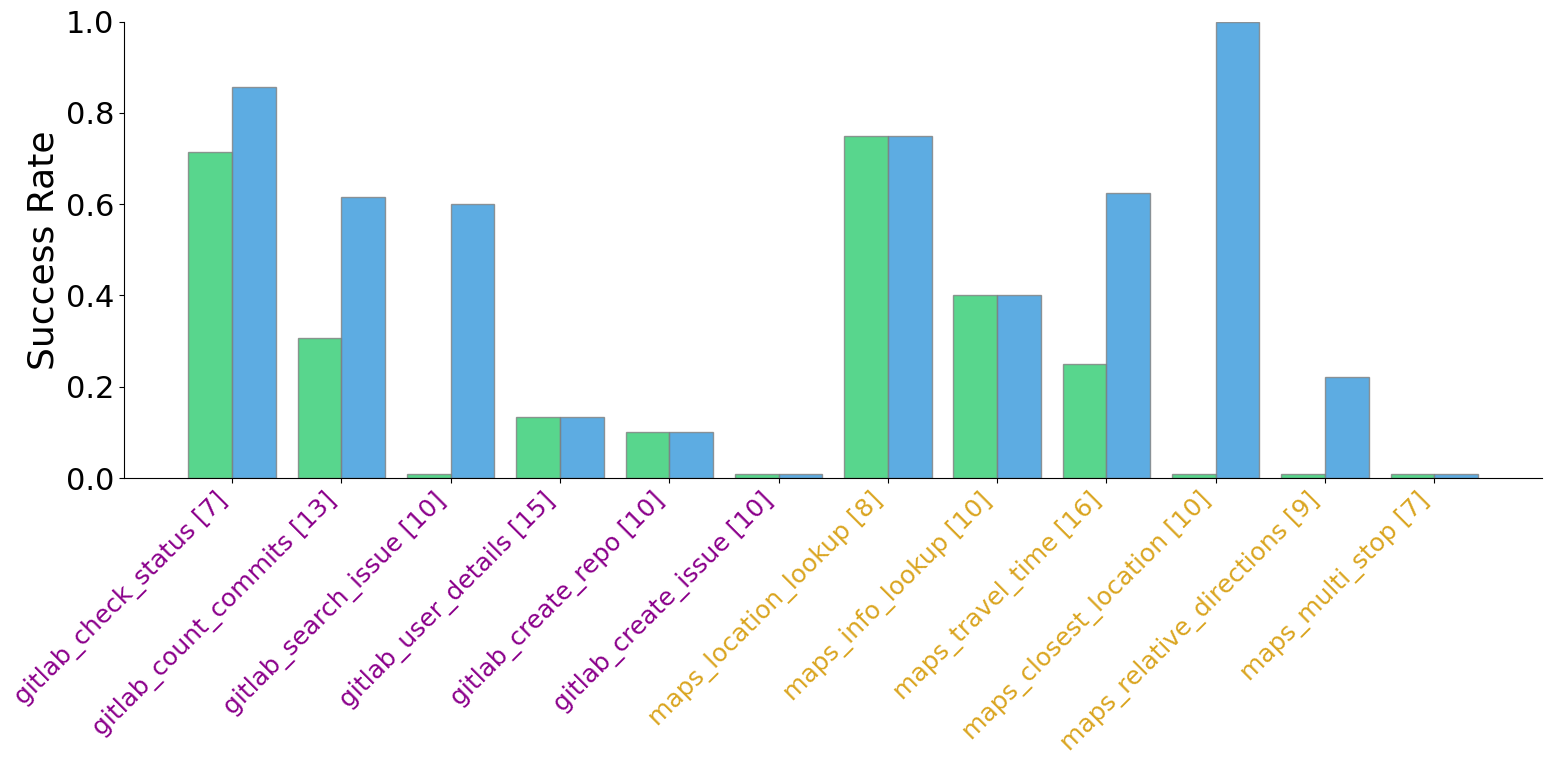

In [76]:
import matplotlib.pyplot as plt

fontsize_plots = 18
plt.rcParams.update({'font.size': fontsize_plots})


plt.figure(figsize=(16, 8))
bar_width = 0.4  # Adjust this for thinner or thicker bars

tasks_toplot = task_list
index = range(len(tasks_toplot))
flat_fewshot_values = filtered_df[filtered_df['policy'] == 'flat_fewshot']['average_success'].values
paw_fewshot_values = filtered_df[filtered_df['policy'] == 'paw_fewshot']['average_success'].values

plt.bar(index, flat_fewshot_values, bar_width, label='flat_fewshot', color='#2ecc71', alpha=0.8, edgecolor='gray')
plt.bar([i+bar_width for i in index], paw_fewshot_values, bar_width, label='paw_fewshot', color='#3498db', alpha=0.8, edgecolor='gray')

#plt.xlabel('Task')
plt.ylabel('Success Rate', fontsize=fontsize_plots+8)
# plt.title('Average Success by Task and Policy')

formatted_task_names = [task_name_mapping[task] for task in tasks_toplot]
plt.yticks(fontsize=fontsize_plots+4)
plt.xticks([i+bar_width/2 for i in index], formatted_task_names, rotation=45, ha='right', fontsize=fontsize_plots)
# plt.legend()
plt.ylim(0, 1)
ax = plt.gca()  # Get the current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for label in ax.get_xticklabels():
    if label.get_text().startswith('maps'):
        label.set_color('#DAA520')  # goldenrod
    elif label.get_text().startswith('gitlab'):
        label.set_color('#8B008B')  # dark magenta

plt.tight_layout()
plt.show()